<a href="https://colab.research.google.com/github/munich-ml/MLPy2021/blob/main/18_Logfiles_w_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logfile challenge

## setup

The setup depends on whether the notebook is executed in **Google Colab** or **locally in Jupyter**.

- Clone GitHub project `MLPy2021` if executed in Colab
- import `parse_logfile_string` from `helper_funcs`
- open file `logfile.csv` and store content into variable `s`


In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

in_colab = 'google.colab' in sys.modules   # check if note is executed within Colab

# Clone the repository if executed in Google Colab
if in_colab:  
    if "MLPy2021" in os.listdir():
        !git -C MLPy2021 pull
    else:
        !git clone https://github.com/munich-ml/MLPy2021/

# The function `parse_logfile_string` from 10_Logfile_challenge.ipynb has been moved 
# lib.helper_funcs.py. The import path depends on Colab or local execution 
if in_colab:
    from MLPy2021.lib.helper_funcs import parse_logfile_string
else:
    from lib.helper_funcs import parse_logfile_string

# Reading the logfile.csv content into the <st> variable s
# The import path depends on Colab or local execution 
if in_colab:
    filename = os.path.join("MLPy2021", "datasets", "logfile.csv")
else:
    filename = os.path.join("datasets", "logfile.csv")

with open(filename, "r") as file:
    s = file.read()

    

Already up to date.


## Reuse functions from **Pandas** session



In [2]:
def parse_logfile_string_to_pandas(s):
    """
    Wraps 'parse_logfile_string' function and converts the "data" list of lists to a Pandas DataFrame
    """
    log = parse_logfile_string(s)
    df = pd.DataFrame(np.array(log["data"]), 
                      columns=log["names"])
    return {"params": log["params"], "data": df}

In [3]:
def apply_calibration(log):
    for param, cal_factor in log["params"].items():
        if "calibration factor" in param:
            sig = param.split(" ")[-1]
            log["data"][sig + "_cal"] = log["data"][sig] * float(cal_factor)

In [4]:
def plot(log, sig_names):
    data = log["data"]
    for sig_name in sig_names:        
        if sig_name in data.columns:
            plt.plot(data["x"], data[sig_name], "o", label=sig_name)
        else:
            print("Warning, '{}' is not in 'log['names']'!".format(sig_name))
    plt.grid(), plt.legend(), plt.tight_layout()
 

## Testing Pandas version

In [5]:
log_data = parse_logfile_string_to_pandas(s)
log_data["data"].head(3)

,x,sig0,sig1,sig2
0,5.17,6.40,16.050,10.610
1,9.47,34.21,5.950,0.293
2,7.65,21.11,0.366,4.800


In [6]:
apply_calibration(log_data)
log_data["data"].head(3)

,x,sig0,sig1,sig2,sig0_cal,sig2_cal
0,5.17,6.40,16.050,10.610,3.5200,19.94680
1,9.47,34.21,5.950,0.293,18.8155,0.55084
2,7.65,21.11,0.366,4.800,11.6105,9.02400


Warning, 'sig1_cal' is not in 'log['names']'!
Warning, 'sig42' is not in 'log['names']'!


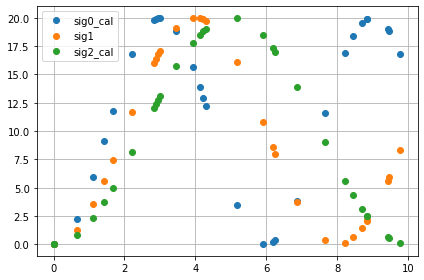

In [7]:
plot(log_data, sig_names=["sig0_cal", "sig1_cal", "sig1", "sig42", "sig2_cal"])

ok, the Pandas version works. 

Next, lets create a **Log `class`**

# `Log` class 


In [8]:
class Log:
    """
    Class handling logfile.csv

    Parameter 'filename' of <type 'str'>
    """
    def __init__(self, filename):
        self.filename = filename
        self._read_and_parse_logfile()

    def __repr__(self):
        s = 50*"#" + "\nLog from file '{}'\n\nparameters:".format(self.filename)
        for param, value in self.params.items():
            s += "\n- '{}' = {}".format(param, value)
        s += "\n\ndata tail:"
        s += "\n" + str(self.data.tail(3))
        return s + "\n" + 50*"#"

    def _read_and_parse_logfile(self):
        with open(self.filename, "r") as file:
            s = file.read()
        log_dict = parse_logfile_string(s)
        self.data = pd.DataFrame(np.array(log_dict["data"]), 
                                 columns=log_dict["names"])
        self.params = log_dict["params"]

    def apply_calibration(self):
        """
        If the parameters contain 'calibration factor' values, those are being applied to the 'sig' data
        """
        for param, cal_factor in self.params.items():
            if "calibration factor" in param:
                sig = param.split(" ")[-1]
                self.data[sig + "_cal"] = self.data[sig] * float(cal_factor)

    def plot(self, sig_names=None):
        """
        plots the 'sig' data over 'x'

        optional parameter 'sig_names' of <type 'list'> of <type 'str'>
        """
        if sig_names is None:
            sig_names = list(self.data.columns)
            sig_names.remove("x")
        
        for sig_name in sig_names:        
            if sig_name in self.data.columns:
                plt.plot(self.data["x"], self.data[sig_name], "o", label=sig_name)
            else:
                print("Warning, '{}' is not in 'data.columns'!".format(sig_name))
        plt.grid(), plt.legend(), plt.tight_layout()

## Testting the `Log` class

In [9]:
fn = os.path.join("MLPy2021", "datasets", "logfile.csv")

In [10]:
log = Log(fn)
log

##################################################
Log from file 'MLPy2021/datasets/logfile.csv'

parameters:
- 'measurement date' = 2021-04-06
- 'measurement time' = 08:00:00
- 'calibration factor sig0' = 0.55
- 'calibration factor sig2' = 1.88

data tail:
       x   sig0   sig1   sig2
27  3.46  34.25  19.13   8.35
28  8.70  35.46   1.46   1.68
29  4.29  22.22  19.75  10.11
##################################################

In [11]:
log.apply_calibration()
log

##################################################
Log from file 'MLPy2021/datasets/logfile.csv'

parameters:
- 'measurement date' = 2021-04-06
- 'measurement time' = 08:00:00
- 'calibration factor sig0' = 0.55
- 'calibration factor sig2' = 1.88

data tail:
       x   sig0   sig1   sig2  sig0_cal  sig2_cal
27  3.46  34.25  19.13   8.35   18.8375   15.6980
28  8.70  35.46   1.46   1.68   19.5030    3.1584
29  4.29  22.22  19.75  10.11   12.2210   19.0068
##################################################

In [12]:
log.data.tail(3)

,x,sig0,sig1,sig2,sig0_cal,sig2_cal
27,3.46,34.25,19.13,8.35,18.8375,15.6980
28,8.70,35.46,1.46,1.68,19.5030,3.1584
29,4.29,22.22,19.75,10.11,12.2210,19.0068


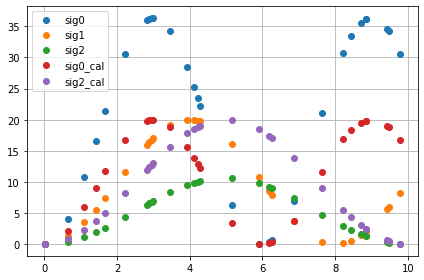

In [13]:
log.plot()